# Stock Price Prediction with Machine Learning



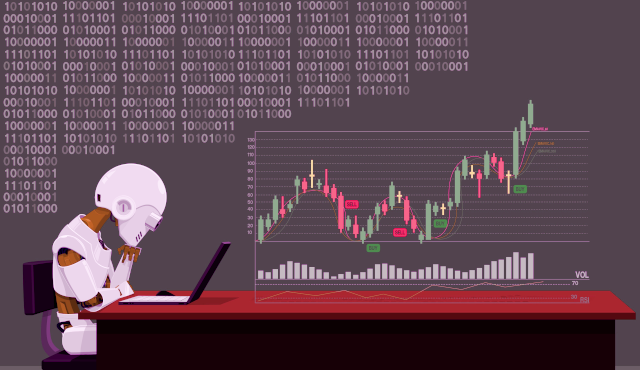

In [19]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Tools for predictive data analysis. We will use the MinMaxScaler to normalize the price data 
from sklearn.preprocessing import MinMaxScaler 
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense
#Displaying Data Interactively
from IPython.display import display , Markdown

# Loading the data

In [20]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Taking a look at the shape of the dataset
print("Number of Rows in the dataset is:",df.shape[0])
print("Number of Columns in the dataset is:",df.shape[1])
display(Markdown('---'))
display(Markdown('##*The starting of the data looks like ...*'))
display(df.head(5))
display(Markdown('---'))
display(Markdown('##*The ending of the data looks like ...*'))
display(df.tail())

Number of Rows in the dataset is: 2854
Number of Columns in the dataset is: 6


---

##*The starting of the data looks like ...*

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980


---

##*The ending of the data looks like ...*

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-29,4218.779785,4176.810059,4206.140137,4211.470215,4288940000,4211.470215
2021-04-30,4198.100098,4174.850098,4198.100098,4181.169922,4273680000,4181.169922
2021-05-03,4209.390137,4188.029785,4191.979980,4192.660156,4061170000,4192.660156
2021-05-04,4179.040039,4128.589844,4179.040039,4164.660156,4441080000,4164.660156
2021-05-05,4187.720215,4160.939941,4177.060059,4167.589844,4029050000,4167.589844


# Exploring the data

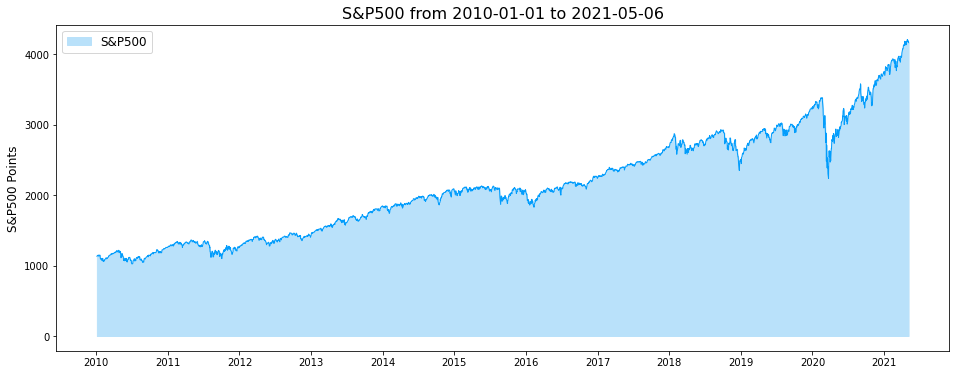

In [21]:
# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
y = df['Close']
ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points', fontsize=12)
plt.show()

# Preprocessing

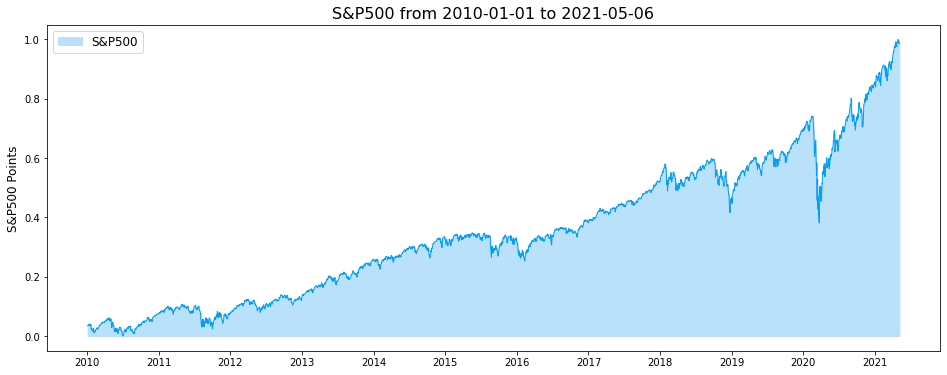

In [22]:
# Create a new dataframe with only the Close column and convert to numpy array
data = df.filter(['Close'])
npdataset = data.values

# Get the number of rows to train the model on 80% of the data 
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)
scaled_data


# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
yt = pd.DataFrame(index=df.index,data=scaled_data.flatten(),columns=['scaled'])#df['Close']
y = yt['scaled']
ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points', fontsize=12)
plt.show()

##*The Data is divided into training and testing subparts*

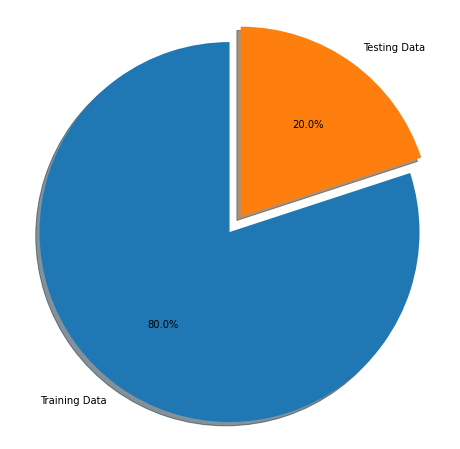

In [23]:
# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data) 
for i in range(100, trainingdatasize):
    x_train.append(train_data[i-100: i, 0]) #contains 100 values 0-100
    y_train.append(train_data[i, 0]) #contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#print(x_train.shape)
#print(y_train.shape)
#print(x_train[0][1][0], y_train[1])

#Plotting the training and testing split
display(Markdown('##*The Data is divided into training and testing subparts*'))
labels = ['Training Data', 'Testing Data']
training_data_size_viz = training_data_length/df.shape[0]
sizes = [training_data_size_viz*100,(1-training_data_size_viz)*100]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Model Training

In [24]:
# Configure the neural network model
model = Sequential()

# Model with 100 Neurons 
# inputshape = 100 Timestamps
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Training the model
history = model.fit(x_train, y_train, batch_size=16, epochs=25,validation_split=0.2)

Epoch 1/25
110/110 [==============================] - 17s 124ms/step - loss: 0.0065 - val_loss: 3.3265e-04
Epoch 2/25
110/110 [==============================] - 14s 129ms/step - loss: 1.1748e-04 - val_loss: 5.7803e-04
Epoch 3/25
110/110 [==============================] - 14s 131ms/step - loss: 1.3778e-04 - val_loss: 2.7460e-04
Epoch 4/25
110/110 [==============================] - 15s 132ms/step - loss: 1.0959e-04 - val_loss: 2.7596e-04
Epoch 5/25
110/110 [==============================] - 14s 130ms/step - loss: 9.7095e-05 - val_loss: 2.3444e-04
Epoch 6/25
110/110 [==============================] - 14s 131ms/step - loss: 1.0354e-04 - val_loss: 2.3798e-04
Epoch 7/25
110/110 [==============================] - 14s 129ms/step - loss: 9.5003e-05 - val_loss: 4.0944e-04
Epoch 8/25
110/110 [==============================] - 15s 132ms/step - loss: 1.0414e-04 - val_loss: 2.7133e-04
Epoch 9/25
110/110 [==============================] - 14s 132ms/step - loss: 9.2428e-05 - val_loss: 1.9542e-04
Epoch

##Loss is reducing as the system is learning

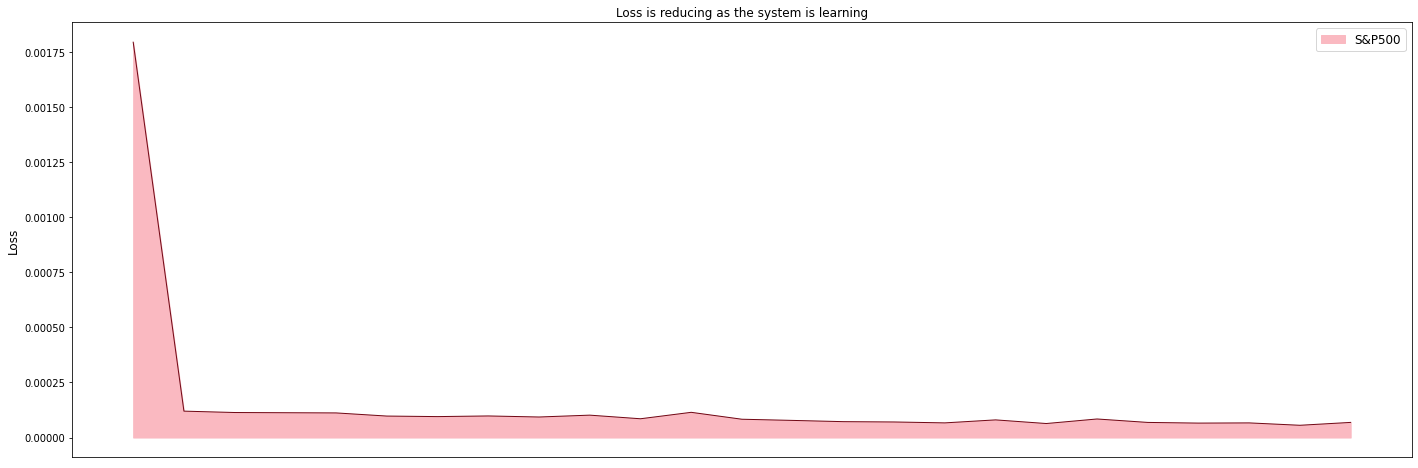

In [26]:
display(Markdown('##Loss is reducing as the system is learning'))
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(24, 8))
ax1.xaxis.set_major_locator(years)
x = np.linspace(0,24,25)
y = history.history['loss']
ax1.fill_between(x, 0, y, color='#fab9c1')
ax1.legend([stockname], fontsize=12)
plt.title("Loss is reducing as the system is learning")
plt.plot(y, color='#710815', label="Loss", linewidth=1.0)
plt.ylabel('Loss', fontsize=12)
plt.show()

In [27]:
# Create a new array containing scaled test values
test_data = scaled_data[training_data_length - 100:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data, so that we get an array with multiple test datasets
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

# Evaluate model performance

###The Evaluation of the Models Performance

>-The Mean Absolute Error is : 37.7

>-The Root Mean Squared Error: 3.4

---

<br/>

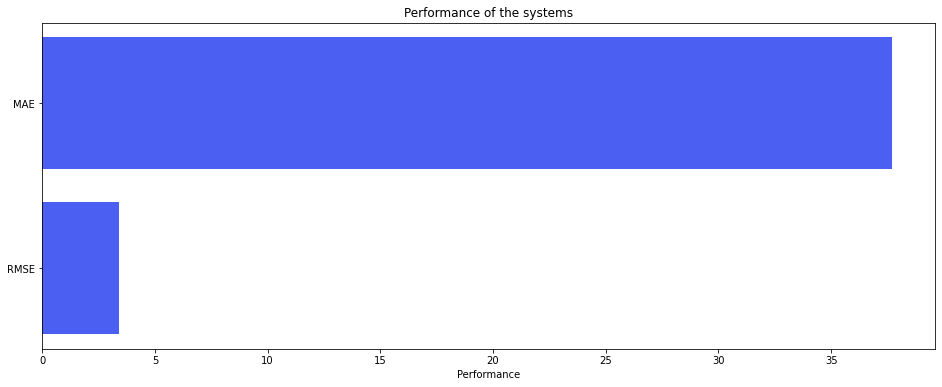

In [29]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(predictions, y_test)
display(Markdown('###The Evaluation of the Models Performance'))
display(Markdown('>-The Mean Absolute Error is : ' + str(round(mae, 1))))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
display(Markdown('>-The Root Mean Squared Error: ' + str(round(rmse, 1))))

display(Markdown('---'))
display(Markdown('<br/>'))

#Plotting performance
fig, ax = plt.subplots(figsize=(16,6))

# Example data
performance = ('MAE', 'RMSE')
y_pos = np.arange(len(performance))
measure = list()
measure.append(mae)
measure.append(rmse)

ax.barh(y_pos, measure, align='center',color='#4b60f2')
ax.set_yticks(y_pos)
ax.set_yticklabels(performance)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Performance of the systems')

plt.show()

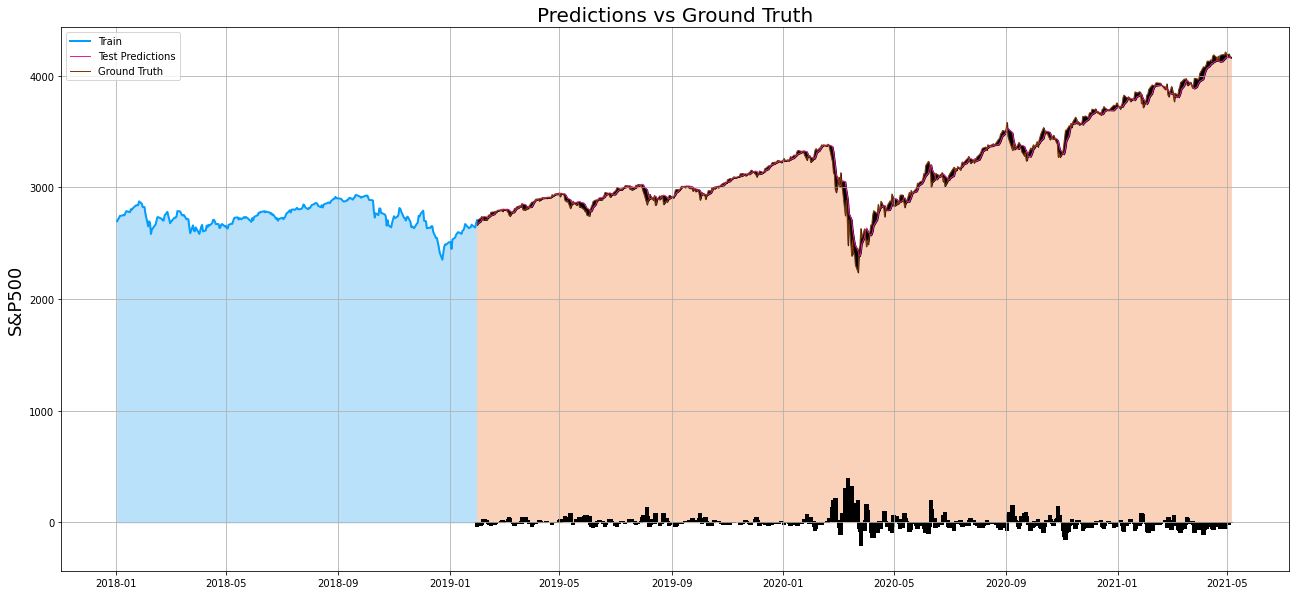

In [30]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(yv["Close"], color="#833809", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#fad2b9")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="black") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

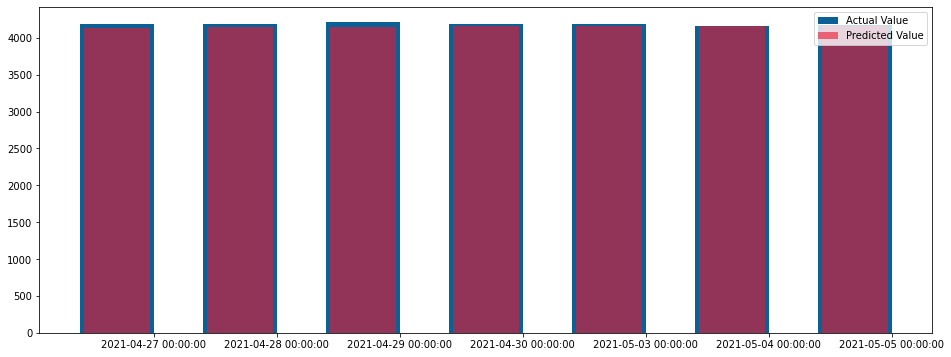

In [31]:
# Show the valid and predicted prices
dif = valid['Close'] - valid['Predictions']
#valid.insert(2, 'Difference', dif, True)
valid.tail(5)


#Plotting the difference
fig, ax1 = plt.subplots(figsize=(16, 6))

width = 0.6

highPower   = list(valid.tail(7)['Close'])
lowPower    = list(valid.tail(7)['Predictions'])

indices = np.arange(len(highPower))

plt.bar(indices, highPower, width=width, 
        color='#0b6096', label='Actual Value')
plt.bar(indices, lowPower, 
        width=0.9*width, color='#ee1530', alpha=0.6, label='Predicted Value')

plt.xticks(indices+width/2, 
           list(valid.tail(7).index) )

plt.legend()

plt.show()


# Predict next day's price

In [33]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
new_df = price_quote.filter(['Close'])

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = mmscaler.transform(new_df[-100:].values)

# Create an empty list and Append past 100 days
X_test = []
X_test.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price = mmscaler.inverse_transform(pred_price)
date_tomorrow = date.today() + timedelta(days=1)
display(Markdown('##The price for ' + stockname + ' at ' + date_today + ' closing time was: ' + '*' + str(round(df.at[df.index.max(), 'Close'])) + '*'))
display(Markdown('##The predicted ' + stockname + ' price at date ' + str(date_tomorrow) + ' at closing will be: ' + '*' + str(round(pred_price[0, 0], 0)) + '*'))

##The price for S&P500 at 2021-05-06 closing time was: *4168*

##The predicted S&P500 price at date 2021-05-07 at closing will be: *4150.0*

In [34]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
new_df = price_quote.filter(['Open'])

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = mmscaler.transform(new_df[-100:].values)

# Create an empty list and Append past 100 days
X_test = []
X_test.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price = mmscaler.inverse_transform(pred_price)
date_tomorrow = date.today() + timedelta(days=1)
display(Markdown('##The price for ' + stockname + ' at ' + date_today + ' opening time was: ' + '*' + str(round(df.at[df.index.max(), 'Close'])) + '*'))
display(Markdown('##The predicted ' + stockname + ' price at date ' + str(date_tomorrow) + ' at opening will be: ' + '*' + str(round(pred_price[0, 0], 0)) + '*'))

##The price for S&P500 at 2021-05-06 opening time was: *4168*

##The predicted S&P500 price at date 2021-05-07 at opening will be: *4160.0*

##Problem Statement

Algorithmic trading has revolutionised the stock market and its surrounding industry. Over 70% of all trades happening all over the world right now are being handled by bots. Gone are the days of the packed stock exchange with suited people waving sheets of paper shouting into telephones.


The problem we are targeting here is to predict the future vale of S&P500 given the past values. Needless to say this would be tremendously helpful for investors. However the key is to predict the value faster with increased accuracy in comparison to classical techniques. Classical technics would involve a team of quantitative analyst, weeks or months of labours pouring over the past data only to come up with a model with not so great accuracy.

##Our Approach
Here we used a techniques in deep learning called Long-Short Term Memory(LSTM) that is used to learning the pattern occuring in a temporal data. This learning is then used to predict the future movement of the data.

##Benifits of our approach over traditional approach
The benifits of our approach is as follows
- Its faster to predict the future value
- Its more accurate compared to performance of traditional approach
- Its adaptable i.e as more data pours in the system learns better and adapt its modelling scheme.
- It can pour over data from over 100 years in minutes and can learn for any pattern occuring thats unnoticeable by human analysts.
